# Make some stacked plots to aid in event selection for the atmospheric analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, correlate, correlation_lags, find_peaks_cwt
from scipy.integrate import trapz
from datetime import datetime, timedelta
from vtools.functions.filter import cosine_lanczos
from vtools.data.vtime import days, hours, minutes
import cmocean

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# filter function

In [2]:
#function comes from schimpy metricsplot.py script https://github.com/CADWRDeltaModeling/schimpy/blob/master/schimpy/metricsplot.py
def filter_timeseries(tss, cutoff_period=hours(40)):
    """ Filter time series

        Parameters
        ----------

        Returns
        -------
        list of vtools.data.timeseries.TimeSeries
            filtered time series
    """

    filtered = []
    ts=tss #try removing the loop for now
    if ts is None:
        filtered.append(None)
    else:
        #print(ts)
        ts_filtered = cosine_lanczos(ts, cutoff_period=cutoff_period)
        ts_filtered.filtered = 'cosine_lanczos'
        #ts_filtered.unit = ts.unit
        #filtered.append(ts_filtered)
    # for ts in tss:
    #     if ts is None:
    #         filtered.append(None)
    #     else:
    #         print(ts)
    #         ts_filtered = cosine_lanczos(ts, cutoff_period=cutoff_period)
    #         ts_filtered.filtered = 'cosine_lanczos'
    #         ts_filtered.unit = ts.unit
    #         filtered.append(ts_filtered)
    return ts_filtered

# Load the Pt reyes subtide

In [3]:
#load the SCHA filtered signal for Point Reyes 
#use Eli's SCHA filter subtide that I then subtracted the 40 day box car from
ptreyes=pd.read_csv("/global/scratch/users/jennaisrael/time_varying_data/tide_gauge_data/bcfiltered_SCHA_subtide_ptreyes.csv")
dtformat = '%Y-%m-%dT%H:%M:%S'
ptreyes['datetime'] = pd.to_datetime(ptreyes['datetime'],format=dtformat)
pr_filt=ptreyes[['datetime','box_40d_filt']].rename(columns={"box_40d_filt": "Residual"})
pr_filt.set_index("datetime",inplace=True)
pr_filt

,Residual
datetime,
2012-01-03 01:30:00,NaN
2012-01-03 02:00:00,NaN
2012-01-03 02:30:00,NaN
2012-01-03 03:00:00,NaN
2012-01-03 03:30:00,NaN
...,...
2023-12-29 20:30:00,NaN
2023-12-29 21:00:00,NaN
2023-12-29 21:30:00,NaN


# Load salinity data

In [4]:
#load the jersey point data, use the sjj signal to gap fill the jer, and load the holland cut salinity data, filter with cosine lanczos filter
jer_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_jer.csv")
jer_dms=jer_dms.rename(columns={"screened/jer//usbr/JER/ec/microS/cm": "Salinity[mS/cm]"})
jer_dms['datetime']=pd.to_datetime(jer_dms['datetime'],format=dtformat)
jer_dms.set_index("datetime",inplace=True)


sjj_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_sjj.csv")
sjj_dms=sjj_dms.rename(columns={"screened/sjj//usgs/11337190/ec/microS/cm": "Salinity[mS/cm]"})
sjj_dms['datetime']=pd.to_datetime(sjj_dms['datetime'],format=dtformat)
sjj_dms.set_index("datetime",inplace=True)

#gapfill
jp=jer_dms.fillna(sjj_dms)
jp=jp.asfreq('15min')
jp_filt=filter_timeseries(jp)

hol2_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_hol2.csv")
hol2_dms=hol2_dms.rename(columns={"screened/hol2//dwr_ncro/B95120/ec/microS/cm": "Salinity[mS/cm]"})
hol2_dms['datetime']=pd.to_datetime(hol2_dms['datetime'],format=dtformat)
hol2_dms.set_index("datetime",inplace=True)
hol2_dms=hol2_dms.asfreq('15min')
hol2_dms_filt=filter_timeseries(hol2_dms)

frk=pd.read_csv('/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/frkdefault_ec_screened_2021.csv',skiprows=65)#.set_index('datetime')
frk=frk.rename(columns={"value": "Salinity[mS/cm]"})
frk['datetime']=pd.to_datetime(frk['datetime'],format=dtformat)
frk.set_index("datetime",inplace=True)
frk=frk.asfreq('15min')
frk_filt=filter_timeseries(frk.drop(columns=['user_flag']))

#put all the variables in one array, need to cut it off before the last array begins (pr 2012-02-12) and before the first array ends (pr 2023-11-19)
df_raw=pd.concat([pr_filt.rename(columns={"Residual": "pr"}),jp_filt.rename(columns={"Salinity[mS/cm]": "jp"}),frk_filt.rename(columns={"Salinity[mS/cm]": "frk"}),hol2_dms_filt.rename(columns={"Salinity[mS/cm]": "hol2"})],axis=1)
df=df_raw.loc[datetime(2012,2,13):datetime(2023,11,18)]#.interpolate()
df['datetime']=df.index.values
df['month']=df.index.month.values
df['year']=df.index.year.values
df_f_wo21=df.mask((df['month']<7) |(df['year']==2021)|(df['year']==2022)) #try leaving in december

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

# Load the flux and pressure data

In [5]:
#read in the flux data so I can plot outflow
flux1=pd.read_csv('/global/scratch/users/jennaisrael/climate_data_processing/sl_regression/flux_from_bdschism_2025_06_05.csv',
                  parse_dates=["datetime"],dtype=np.float32).set_index(["datetime"])#, names=['time','coyote','ccc_rock','ccc_old','swp','cvp','sjr','calaveras','east','american','sac','yolo_toedrain','yolo','northbay','napa','ccc_victoria'])
flux1=flux1.asfreq('15min')
flux1['sac_sjr']=flux1['sac']+flux1['sjr']
# Add a column for total exports, sum of State water project and Central Valley water project 
flux1['exports']=flux1['swp']+flux1['cvp']

In [6]:
#Down sample to make it easier to plot
fluxc=flux1.resample('d').sum()
fluxc['md']=fluxc.index.strftime('%m-%d')
fluxc['xaxis']=pd.to_datetime('2004-'+fluxc['md'],format='%Y-%m-%d') #needs to be a leap year

In [7]:
# Load the psl anomaly and tide gauge data
df_m=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/sl_regression/monterey.regression.data.hourly.1996.2020.csv",parse_dates=['time']).set_index(['time'])
#Residual calculated by subtracting from utide predicted tide, see notebook /global/scratch/users/jennaisrael/climate_data_processing/sl_regression/detrended_residuals_utide.ipynb
df_pr=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/sl_regression/point_reyes.regression.data.hourly.1996.2020.csv",parse_dates=['time']).set_index(['time'])
df_m

,u10_stress_a,v10_stress_a,msl_a,sst_a,PDO_a,EN3.4_a,Residual
time,,,,,,,
1995-12-31 16:00:00,8.956125,-43.981939,736.900563,0.659997,0.836933,-1.306148,-0.041708
1995-12-31 17:00:00,5.255560,-33.640463,771.835528,0.659997,0.836933,-1.306148,-0.049622
1995-12-31 18:00:00,4.653470,-29.136661,734.585493,0.659997,0.836933,-1.306148,-0.050717
1995-12-31 19:00:00,7.100264,-24.445409,689.835457,0.659997,0.836933,-1.306148,-0.043857
1995-12-31 20:00:00,15.985210,-32.178663,623.085422,0.659997,0.836933,-1.306148,-0.056559
...,...,...,...,...,...,...,...
2021-10-01 19:00:00,-1.437500,0.301881,-145.706222,1.620365,-2.707063,-1.352207,-0.005646
2021-10-01 20:00:00,1.117509,-0.157175,-153.396257,1.620364,-2.707063,-1.352207,-0.015753
2021-10-01 21:00:00,1.308850,0.070465,-179.146292,1.620364,-2.707063,-1.352207,-0.019239


# identify peaks

In [8]:
#control on min and max length of event
maxw=30*24*4 #60*24*4
minw=2

In [9]:
#first find the datetimes with peaks at all locations, store them in logical columns e.g. pr_peak
#seems to be using the whole summer as a peak sometimes, set max width of 2 months 

peakspr, propertiespr = find_peaks(df_f_wo21.pr.dropna().values, height=0,width=(2,maxw))#,width=(0,maxw)) #this just gives the x locations of the peaks, need to convert to logical
pr_indices = df_f_wo21.pr.dropna().index
peaksjp, propertiesjp = find_peaks(df_f_wo21.jp.dropna().values, prominence=10,width=(0,maxw))
jp_indices = df_f_wo21.jp.dropna().index
peakshol2, propertieshol2 = find_peaks(df_f_wo21.hol2.dropna().values, prominence=5,width=(0,maxw))
hol2_indices = df_f_wo21.hol2.dropna().index
peaksfrk, propertiesfrk = find_peaks(df_f_wo21.frk.dropna().values, prominence=5,width=(0,maxw))
frk_indices = df_f_wo21.frk.dropna().index
#peakshol210, _ = find_peaks(df_f_wo21.hol2.values, prominence=10)
idx=np.arange(0,len(df_f_wo21.pr.values))#has the same shape as the first argument
df_f_wo21['pr_peak']=np.isin(df_f_wo21.index,pr_indices[peakspr]) #for this one need to map from the nan dropped list to full list
df_f_wo21['jp_peak']=np.isin(df_f_wo21.index,jp_indices[peaksjp])
df_f_wo21['hol2_peak']=np.isin(df_f_wo21.index,hol2_indices[peakshol2])
df_f_wo21['frk_peak']=np.isin(df_f_wo21.index,frk_indices[peaksfrk])
df_f_wo21

,pr,jp,frk,hol2,datetime,month,year,pr_peak,jp_peak,hol2_peak,frk_peak
datetime,,,,,,,,,,,
2012-02-13 00:00:00,NaN,NaN,NaN,NaN,NaT,NaN,NaN,False,False,False,False
2012-02-13 00:15:00,NaN,NaN,NaN,NaN,NaT,NaN,NaN,False,False,False,False
2012-02-13 00:30:00,NaN,NaN,NaN,NaN,NaT,NaN,NaN,False,False,False,False
2012-02-13 00:45:00,NaN,NaN,NaN,NaN,NaT,NaN,NaN,False,False,False,False
2012-02-13 01:00:00,NaN,NaN,NaN,NaN,NaT,NaN,NaN,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-17 23:00:00,0.206520,1067.342768,205.590816,216.022549,2023-11-17 23:00:00,11.0,2023.0,False,False,False,False
2023-11-17 23:15:00,NaN,1069.722160,205.787840,216.071901,2023-11-17 23:15:00,11.0,2023.0,False,False,False,False
2023-11-17 23:30:00,0.207101,1072.129574,205.988822,216.120777,2023-11-17 23:30:00,11.0,2023.0,False,False,False,False


In [10]:
print(df_f_wo21['pr_peak'].sum())
print(df_f_wo21['jp_peak'].sum())
print(df_f_wo21['frk_peak'].sum())
print(df_f_wo21['hol2_peak'].sum())

360
286
82
150


# filter peaks to the ones that appear in hol2 and frk

In [11]:
#how far to search for an event beyond the point reyes peak
win=27 #number of samples in 24 hours
winh=177
#make an array of ones to multiply by the true false
ov=np.ones_like(df_f_wo21['pr_peak'].values)

In [12]:
# as a first pass, how many events are there where there is a true value in all columns in the 24 hours after the pr peak?
peak_pr24h_1=np.datetime64()
peak_jp24h_1=np.datetime64()
peak_hol224h=np.datetime64()

# win=24 #number of samples in 24 hours
# winh=win*5
count_j=0
count_h=0
count_dup=0
old_hol2_time=pr_indices[0]
for p in peakspr:
    #need to map this index back to the data frame
    x=pr_indices[p]
    x2=x+pd.Timedelta(hours=win)
    x3=x+pd.Timedelta(hours=winh)
    if df_f_wo21.jp_peak[x:x2].sum()>0:
        jp_time=(x+pd.Timedelta(minutes=df_f_wo21.jp_peak[x:x2].argmax()*15)).to_datetime64()
        count_j=count_j+1
        if df_f_wo21.hol2_peak[x:x3].sum()>0: 
            hol2_time=(x+pd.Timedelta(minutes=df_f_wo21.hol2_peak[x:x3].argmax()*15)).to_datetime64()
            if hol2_time>jp_time: #and old_hol2_time!=hol2_time: #don't save the duplicate events
                count_h=count_h+1
                peak_pr24h_1=np.append(peak_pr24h_1,x.to_datetime64())
                #these should be in real time (don't drop na)
                peak_jp24h_1=np.append(peak_jp24h_1,jp_time)
                peak_hol224h=np.append(peak_hol224h,hol2_time)
            if old_hol2_time==hol2_time:
                count_dup=count_dup+1
            old_hol2_time=hol2_time
idx=np.arange(0,len(df_f_wo21.pr.values))

print(count_j)
print(count_h)
print(count_dup)
#df_f_wo21['all_peak_24h']=np.isin(idx,peak_pr24h)

148
69
13


In [13]:
# as a first pass, how many events are there where there is a true value in all columns in the 24 hours after the pr peak?
peak_pr24h_2=np.datetime64()
peak_jp24h_2=np.datetime64()
peak_frk24h=np.datetime64()

# win=24 #number of samples in 24 hours
# winh=win*5
count_j=0
count_h=0
count_dup=0
old_frk_time=pr_indices[0]
for p in peakspr:
    #need to map this index back to the data frame
    x=pr_indices[p]
    x2=x+pd.Timedelta(hours=win)
    x3=x+pd.Timedelta(hours=winh)
    if df_f_wo21.jp_peak[x:x2].sum()>0:
        jp_time=(x+pd.Timedelta(minutes=df_f_wo21.jp_peak[x:x2].argmax()*15)).to_datetime64()
        count_j=count_j+1
        if df_f_wo21.frk_peak[x:x3].sum()>0: 
            frk_time=(x+pd.Timedelta(minutes=df_f_wo21.frk_peak[x:x3].argmax()*15)).to_datetime64()
            if frk_time>jp_time:
                count_h=count_h+1
                peak_pr24h_2=np.append(peak_pr24h_2,x.to_datetime64())
                #these should be in real time (don't drop na)
                peak_jp24h_2=np.append(peak_jp24h_2,jp_time)
                peak_frk24h=np.append(peak_frk24h,frk_time)
            if old_frk_time==frk_time:
                count_dup=count_dup+1
            old_frk_time=frk_time
idx=np.arange(0,len(df_f_wo21.pr.values))

print(count_j)
print(count_h)
print(count_dup)
#df_f_wo21['all_peak_24h']=np.isin(idx,peak_pr24h)

148
51
10


In [14]:
#trim the NaT from the beginning of the arrays
peak_pr24h_1=peak_pr24h_1[1:]
peak_pr24h_2=peak_pr24h_2[1:]
peak_jp24h_1=peak_jp24h_1[1:]
peak_jp24h_2=peak_jp24h_2[1:]
peak_hol224h=peak_hol224h[1:]
peak_frk24h=peak_frk24h[1:]

In [15]:
#how many peak_pr and peak_jp are the same between 1 and 2 (identified using frk versus hol2)
peak_pr_both, ind_pr_1,ind_pr_2 =np.intersect1d(peak_pr24h_1,peak_pr24h_2,return_indices=True)
peak_jp_both, ind_jp_1,ind_jp_2=np.intersect1d(peak_jp24h_1,peak_jp24h_2,return_indices=True)
print(len(peak_pr_both))
print(len(peak_jp_both))

29
29


In [16]:
#now need to index the associated franks tract and hol2 
#are ind_pr_1 and ind_jp_1 the same?
if np.array_equal(ind_pr_1,ind_jp_1)==True:
    print('hol2 indices are the same')
if np.array_equal(ind_pr_2,ind_jp_2)==True:
    print('frk indices are the same')

hol2 indices are the same
frk indices are the same


In [17]:
# Look at these 29 dates, try plotting all the curves together
peak_hol2_both=peak_hol224h[ind_pr_1]
peak_frk_both=peak_frk24h[ind_pr_2]
#events occured in 2015, 2016, 2017 (just 1), 2018, 2019, 2020

# make stacked plots for 2015, 2016, 2017 (just 1 event), 2018, 2019, 2020

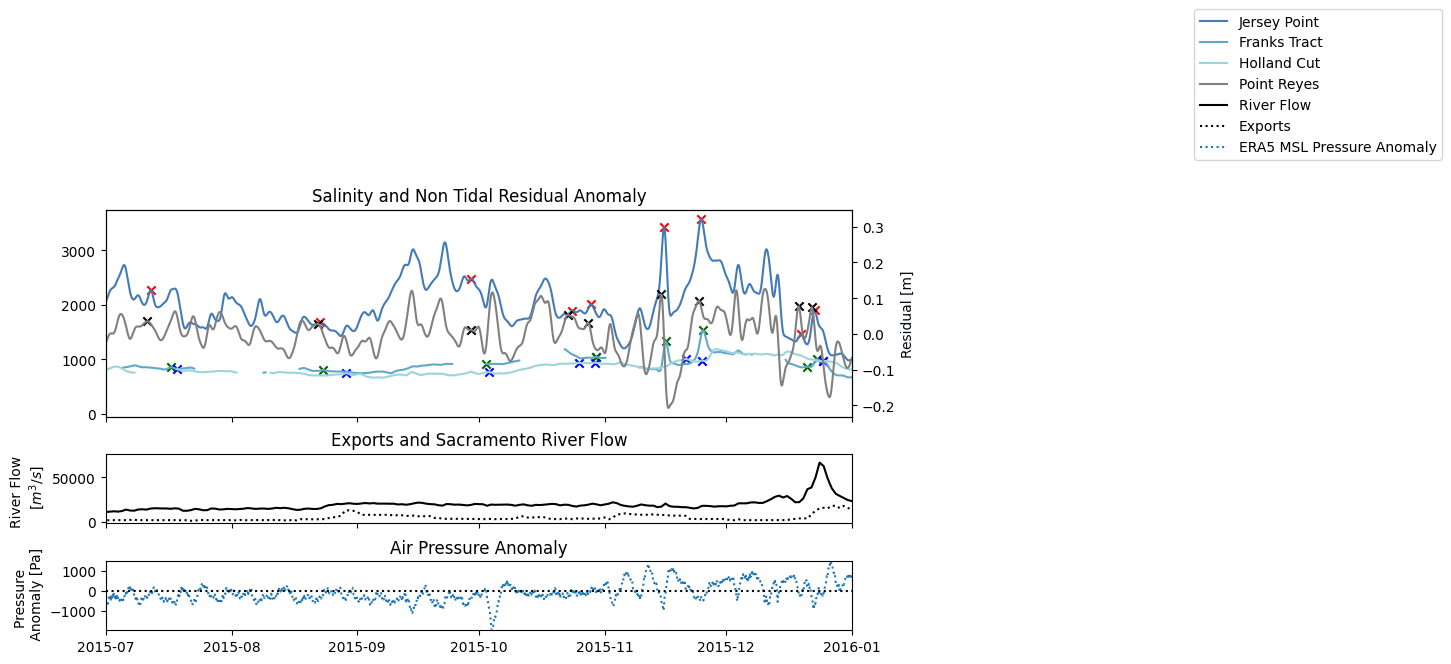

In [39]:
# Try plotting exports and river flow on a second thin subplot below the salinity and elevation plot and then a third plot for sea level pressure
fig, ax = plt.subplots(3,1,layout="constrained",sharex=True,figsize=(11,6),gridspec_kw={'height_ratios': [3, 1, 1]})

#Set the date limits of the plot HERE so I can rescale the axes by min and max in this range 
lim1=datetime(2015,7,1)
lim2=datetime(2016,1,1)
#colors to be consistent with other plors
colors = plt.colormaps['Dark2'].colors #this is a tuple so need to use tuple indexing [rom][column]


a, = ax[0].plot(df_f_wo21.jp,color=cmocean.cm.ice(3/6),label="Jersey Point")
ax[0].scatter(df_f_wo21.datetime.loc[peak_jp_both],df_f_wo21.jp.loc[peak_jp_both],marker="x",color='r')
b, = ax[0].plot(df_f_wo21.frk,color=cmocean.cm.ice(4/6),label="Franks Tract")
ax[0].scatter(df_f_wo21.datetime.loc[peak_frk_both],df_f_wo21.frk.loc[peak_frk_both],marker="x",color='darkgreen')
c, = ax[0].plot(df_f_wo21.hol2,color=cmocean.cm.ice(5/6),label="Holland Cut")
ax[0].scatter(df_f_wo21.datetime.loc[peak_hol2_both],df_f_wo21.hol2.loc[peak_hol2_both],marker="x",color='b')
ax0=ax[0].twinx()
d, = ax0.plot(pr_indices,df_f_wo21.pr.dropna(),color='grey', label="Point Reyes")
ax0.scatter(df_f_wo21.datetime.loc[peak_pr_both], df_f_wo21.pr.loc[peak_pr_both],marker="x",color='k')
ax0.set_ylabel("Residual [m]",color=cmocean.cm.ice(0))
ax[0].set_title('Salinity and Non Tidal Residual Anomaly')

e, = ax[1].plot(fluxc['sac_sjr']*-1, label="River Flow", color='k')
f, = ax[1].plot(fluxc['exports'], label="Exports", color='k',linestyle=':')
min1=fluxc[lim1:lim2][['sac_sjr','exports']].abs().min(axis=None).min()-2500
max1=fluxc[lim1:lim2][['sac_sjr','exports']].abs().max(axis=None).max()+10000
ax[1].set_ylim([min1,max1])
ax[1].set_ylabel("River Flow \n [$m^3/s$]")
ax[1].set_title('Exports and Sacramento River Flow')
#ax[1].legend()

g, = ax[2].plot(df_pr['msl_a'],label='ERA5 MSL Pressure Anomaly',linestyle=':')
min2=df_pr['msl_a'][lim1:lim2].min()-5
max2=df_pr['msl_a'][lim1:lim2].max()+5
ax[2].set_ylim([min2,max2])
ax[2].set_ylabel("Pressure \n Anomaly [Pa]")
ax[2].axhline(y=0, color = 'k',linestyle=':')
ax[2].set_title('Air Pressure Anomaly')

ax[0].set_xlim(lim1,lim2)
leg = plt.legend(handles=[a,b,c,d,e,f,g],loc='upper right', bbox_to_anchor=(1.8, 2.0))
plt.show()



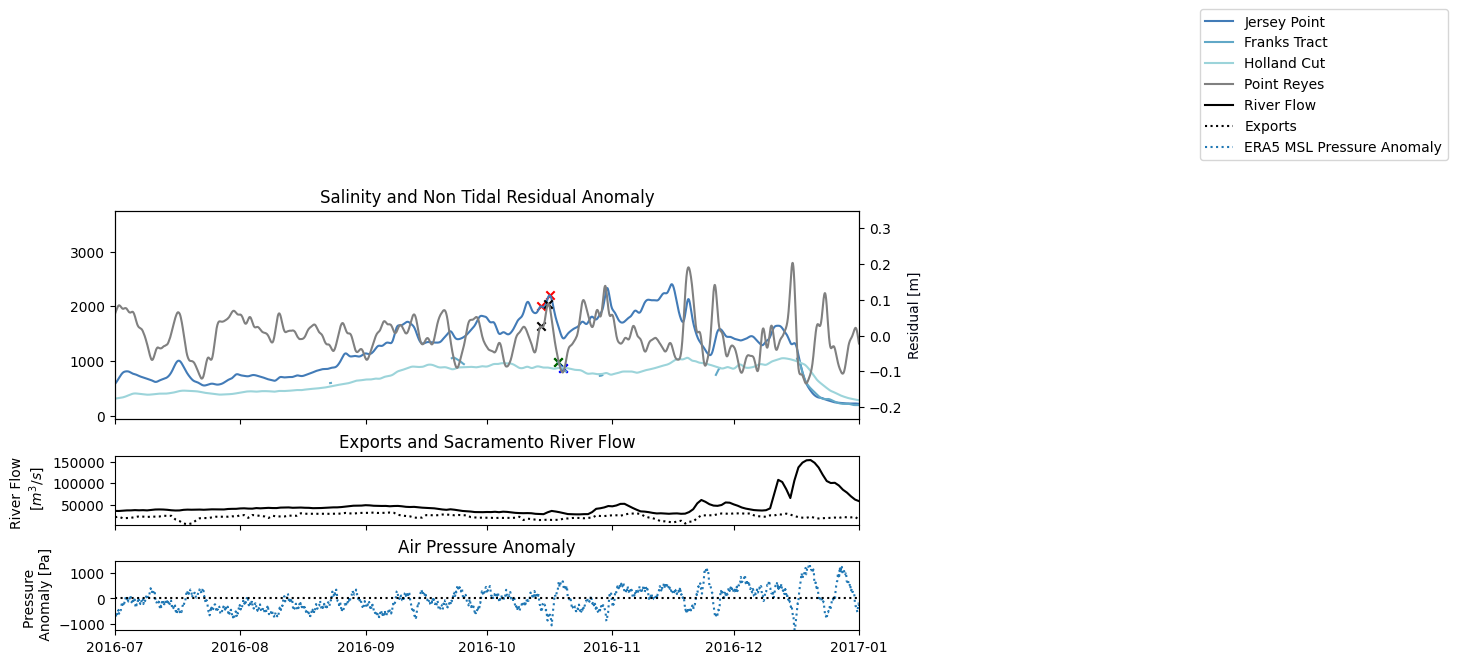

In [40]:
# Try plotting exports and river flow on a second thin subplot below the salinity and elevation plot and then a third plot for sea level pressure
fig, ax = plt.subplots(3,1,layout="constrained",sharex=True,figsize=(11,6),gridspec_kw={'height_ratios': [3, 1, 1]})

#Set the date limits of the plot HERE so I can rescale the axes by min and max in this range 
lim1=datetime(2016,7,1)
lim2=datetime(2017,1,1)
#colors to be consistent with other plors
colors = plt.colormaps['Dark2'].colors #this is a tuple so need to use tuple indexing [rom][column]


a, = ax[0].plot(df_f_wo21.jp,color=cmocean.cm.ice(3/6),label="Jersey Point")
ax[0].scatter(df_f_wo21.datetime.loc[peak_jp_both],df_f_wo21.jp.loc[peak_jp_both],marker="x",color='r')
b, = ax[0].plot(df_f_wo21.frk,color=cmocean.cm.ice(4/6),label="Franks Tract")
ax[0].scatter(df_f_wo21.datetime.loc[peak_frk_both],df_f_wo21.frk.loc[peak_frk_both],marker="x",color='darkgreen')
c, = ax[0].plot(df_f_wo21.hol2,color=cmocean.cm.ice(5/6),label="Holland Cut")
ax[0].scatter(df_f_wo21.datetime.loc[peak_hol2_both],df_f_wo21.hol2.loc[peak_hol2_both],marker="x",color='b')
ax0=ax[0].twinx()
d, = ax0.plot(pr_indices,df_f_wo21.pr.dropna(),color='grey', label="Point Reyes")
ax0.scatter(df_f_wo21.datetime.loc[peak_pr_both], df_f_wo21.pr.loc[peak_pr_both],marker="x",color='k')
ax0.set_ylabel("Residual [m]",color=cmocean.cm.ice(0))
ax[0].set_title('Salinity and Non Tidal Residual Anomaly')

e, = ax[1].plot(fluxc['sac_sjr']*-1, label="River Flow", color='k')
f, = ax[1].plot(fluxc['exports'], label="Exports", color='k',linestyle=':')
min1=fluxc[lim1:lim2][['sac_sjr','exports']].abs().min(axis=None).min()-2500
max1=fluxc[lim1:lim2][['sac_sjr','exports']].abs().max(axis=None).max()+10000
ax[1].set_ylim([min1,max1])
ax[1].set_ylabel("River Flow \n [$m^3/s$]")
ax[1].set_title('Exports and Sacramento River Flow')
#ax[1].legend()

g, = ax[2].plot(df_pr['msl_a'],label='ERA5 MSL Pressure Anomaly',linestyle=':')
min2=df_pr['msl_a'][lim1:lim2].min()-5
max2=df_pr['msl_a'][lim1:lim2].max()+5
ax[2].set_ylim([min2,max2])
ax[2].set_ylabel("Pressure \n Anomaly [Pa]")
ax[2].axhline(y=0, color = 'k',linestyle=':')
ax[2].set_title('Air Pressure Anomaly')

ax[0].set_xlim(lim1,lim2)
leg = plt.legend(handles=[a,b,c,d,e,f,g],loc='upper right', bbox_to_anchor=(1.8, 2.0))
plt.show()



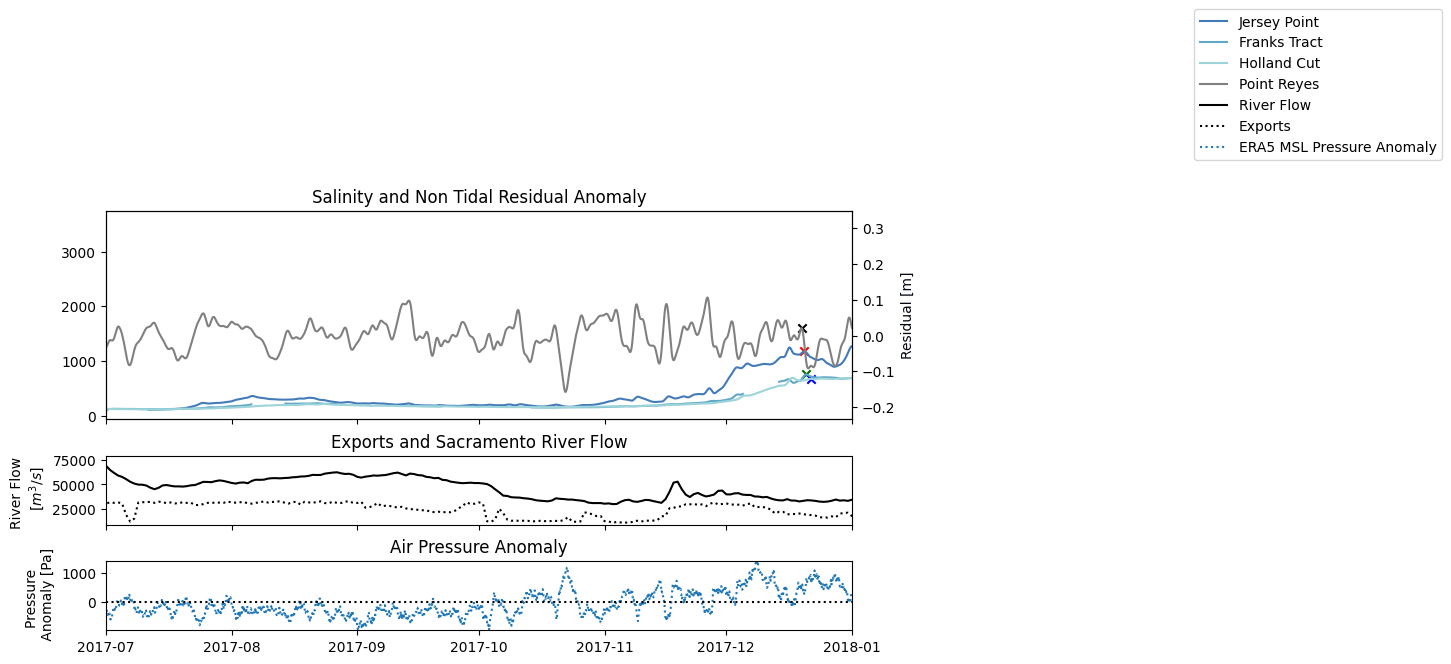

In [41]:
# Try plotting exports and river flow on a second thin subplot below the salinity and elevation plot and then a third plot for sea level pressure
fig, ax = plt.subplots(3,1,layout="constrained",sharex=True,figsize=(11,6),gridspec_kw={'height_ratios': [3, 1, 1]})

#Set the date limits of the plot HERE so I can rescale the axes by min and max in this range 
lim1=datetime(2017,7,1)
lim2=datetime(2018,1,1)
#colors to be consistent with other plors
colors = plt.colormaps['Dark2'].colors #this is a tuple so need to use tuple indexing [rom][column]


a, = ax[0].plot(df_f_wo21.jp,color=cmocean.cm.ice(3/6),label="Jersey Point")
ax[0].scatter(df_f_wo21.datetime.loc[peak_jp_both],df_f_wo21.jp.loc[peak_jp_both],marker="x",color='r')
b, = ax[0].plot(df_f_wo21.frk,color=cmocean.cm.ice(4/6),label="Franks Tract")
ax[0].scatter(df_f_wo21.datetime.loc[peak_frk_both],df_f_wo21.frk.loc[peak_frk_both],marker="x",color='darkgreen')
c, = ax[0].plot(df_f_wo21.hol2,color=cmocean.cm.ice(5/6),label="Holland Cut")
ax[0].scatter(df_f_wo21.datetime.loc[peak_hol2_both],df_f_wo21.hol2.loc[peak_hol2_both],marker="x",color='b')
ax0=ax[0].twinx()
d, = ax0.plot(pr_indices,df_f_wo21.pr.dropna(),color='grey', label="Point Reyes")
ax0.scatter(df_f_wo21.datetime.loc[peak_pr_both], df_f_wo21.pr.loc[peak_pr_both],marker="x",color='k')
ax0.set_ylabel("Residual [m]",color=cmocean.cm.ice(0))
ax[0].set_title('Salinity and Non Tidal Residual Anomaly')

e, = ax[1].plot(fluxc['sac_sjr']*-1, label="River Flow", color='k')
f, = ax[1].plot(fluxc['exports'], label="Exports", color='k',linestyle=':')
min1=fluxc[lim1:lim2][['sac_sjr','exports']].abs().min(axis=None).min()-2500
max1=fluxc[lim1:lim2][['sac_sjr','exports']].abs().max(axis=None).max()+10000
ax[1].set_ylim([min1,max1])
ax[1].set_ylabel("River Flow \n [$m^3/s$]")
ax[1].set_title('Exports and Sacramento River Flow')
#ax[1].legend()

g, = ax[2].plot(df_pr['msl_a'],label='ERA5 MSL Pressure Anomaly',linestyle=':')
min2=df_pr['msl_a'][lim1:lim2].min()-5
max2=df_pr['msl_a'][lim1:lim2].max()+5
ax[2].set_ylim([min2,max2])
ax[2].set_ylabel("Pressure \n Anomaly [Pa]")
ax[2].axhline(y=0, color = 'k',linestyle=':')
ax[2].set_title('Air Pressure Anomaly')

ax[0].set_xlim(lim1,lim2)
leg = plt.legend(handles=[a,b,c,d,e,f,g],loc='upper right', bbox_to_anchor=(1.8, 2.0))
plt.show()



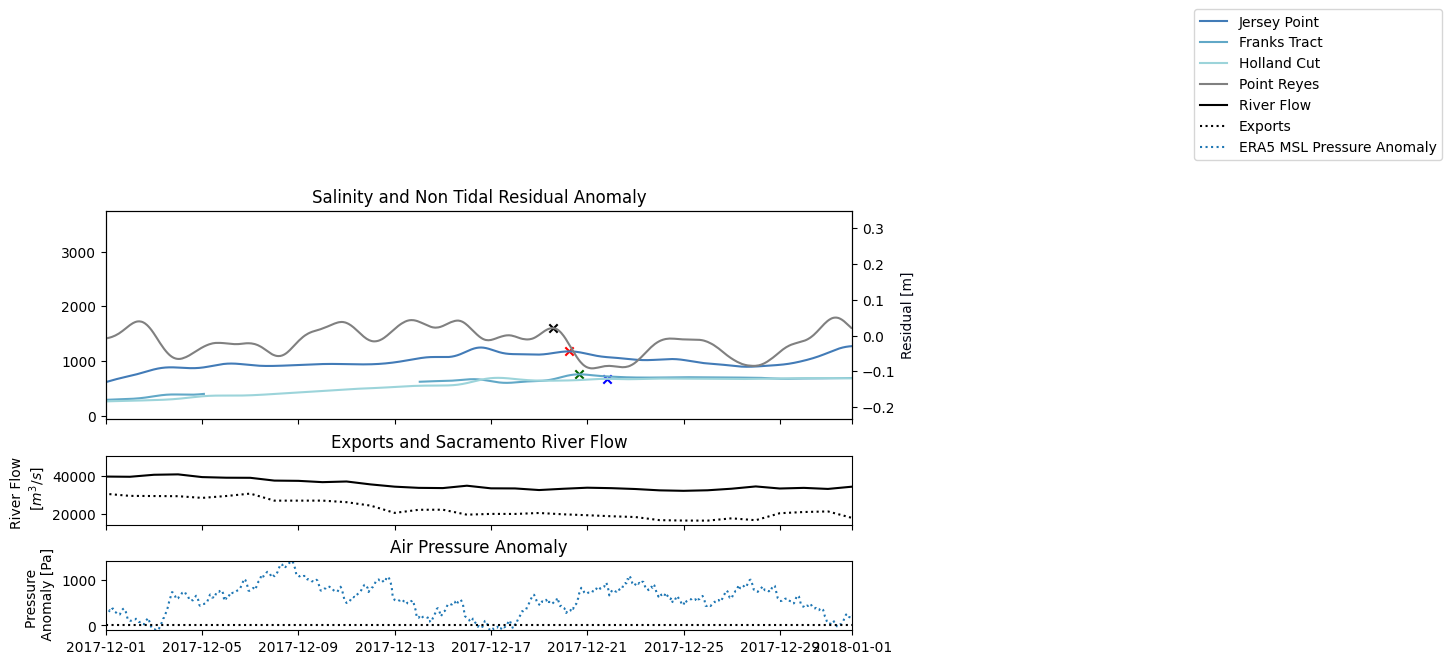

In [42]:
# Try plotting exports and river flow on a second thin subplot below the salinity and elevation plot and then a third plot for sea level pressure
fig, ax = plt.subplots(3,1,layout="constrained",sharex=True,figsize=(11,6),gridspec_kw={'height_ratios': [3, 1, 1]})

#Set the date limits of the plot HERE so I can rescale the axes by min and max in this range 
lim1=datetime(2017,12,1)
lim2=datetime(2018,1,1)
#colors to be consistent with other plors
colors = plt.colormaps['Dark2'].colors #this is a tuple so need to use tuple indexing [rom][column]


a, = ax[0].plot(df_f_wo21.jp,color=cmocean.cm.ice(3/6),label="Jersey Point")
ax[0].scatter(df_f_wo21.datetime.loc[peak_jp_both],df_f_wo21.jp.loc[peak_jp_both],marker="x",color='r')
b, = ax[0].plot(df_f_wo21.frk,color=cmocean.cm.ice(4/6),label="Franks Tract")
ax[0].scatter(df_f_wo21.datetime.loc[peak_frk_both],df_f_wo21.frk.loc[peak_frk_both],marker="x",color='darkgreen')
c, = ax[0].plot(df_f_wo21.hol2,color=cmocean.cm.ice(5/6),label="Holland Cut")
ax[0].scatter(df_f_wo21.datetime.loc[peak_hol2_both],df_f_wo21.hol2.loc[peak_hol2_both],marker="x",color='b')
ax0=ax[0].twinx()
d, = ax0.plot(pr_indices,df_f_wo21.pr.dropna(),color='grey', label="Point Reyes")
ax0.scatter(df_f_wo21.datetime.loc[peak_pr_both], df_f_wo21.pr.loc[peak_pr_both],marker="x",color='k')
ax0.set_ylabel("Residual [m]",color=cmocean.cm.ice(0))
ax[0].set_title('Salinity and Non Tidal Residual Anomaly')

e, = ax[1].plot(fluxc['sac_sjr']*-1, label="River Flow", color='k')
f, = ax[1].plot(fluxc['exports'], label="Exports", color='k',linestyle=':')
min1=fluxc[lim1:lim2][['sac_sjr','exports']].abs().min(axis=None).min()-2500
max1=fluxc[lim1:lim2][['sac_sjr','exports']].abs().max(axis=None).max()+10000
ax[1].set_ylim([min1,max1])
ax[1].set_ylabel("River Flow \n [$m^3/s$]")
ax[1].set_title('Exports and Sacramento River Flow')
#ax[1].legend()

g, = ax[2].plot(df_pr['msl_a'],label='ERA5 MSL Pressure Anomaly',linestyle=':')
min2=df_pr['msl_a'][lim1:lim2].min()-5
max2=df_pr['msl_a'][lim1:lim2].max()+5
ax[2].set_ylim([min2,max2])
ax[2].set_ylabel("Pressure \n Anomaly [Pa]")
ax[2].axhline(y=0, color = 'k',linestyle=':')
ax[2].set_title('Air Pressure Anomaly')

ax[0].set_xlim(lim1,lim2)
leg = plt.legend(handles=[a,b,c,d,e,f,g],loc='upper right', bbox_to_anchor=(1.8, 2.0))
plt.show()



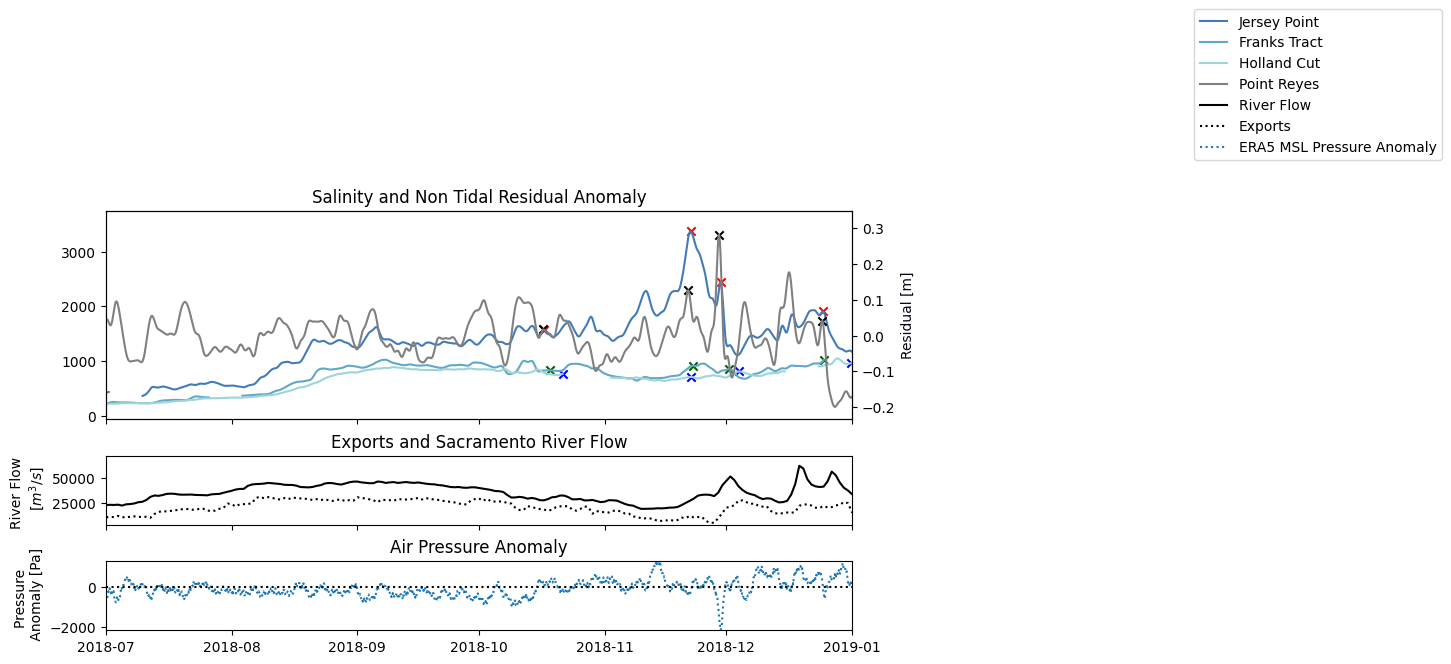

In [43]:
# Try plotting exports and river flow on a second thin subplot below the salinity and elevation plot and then a third plot for sea level pressure
fig, ax = plt.subplots(3,1,layout="constrained",sharex=True,figsize=(11,6),gridspec_kw={'height_ratios': [3, 1, 1]})

#Set the date limits of the plot HERE so I can rescale the axes by min and max in this range 
lim1=datetime(2018,7,1)
lim2=datetime(2019,1,1)
#colors to be consistent with other plors
colors = plt.colormaps['Dark2'].colors #this is a tuple so need to use tuple indexing [rom][column]


a, = ax[0].plot(df_f_wo21.jp,color=cmocean.cm.ice(3/6),label="Jersey Point")
ax[0].scatter(df_f_wo21.datetime.loc[peak_jp_both],df_f_wo21.jp.loc[peak_jp_both],marker="x",color='r')
b, = ax[0].plot(df_f_wo21.frk,color=cmocean.cm.ice(4/6),label="Franks Tract")
ax[0].scatter(df_f_wo21.datetime.loc[peak_frk_both],df_f_wo21.frk.loc[peak_frk_both],marker="x",color='darkgreen')
c, = ax[0].plot(df_f_wo21.hol2,color=cmocean.cm.ice(5/6),label="Holland Cut")
ax[0].scatter(df_f_wo21.datetime.loc[peak_hol2_both],df_f_wo21.hol2.loc[peak_hol2_both],marker="x",color='b')
ax0=ax[0].twinx()
d, = ax0.plot(pr_indices,df_f_wo21.pr.dropna(),color='grey', label="Point Reyes")
ax0.scatter(df_f_wo21.datetime.loc[peak_pr_both], df_f_wo21.pr.loc[peak_pr_both],marker="x",color='k')
ax0.set_ylabel("Residual [m]",color=cmocean.cm.ice(0))
ax[0].set_title('Salinity and Non Tidal Residual Anomaly')

e, = ax[1].plot(fluxc['sac_sjr']*-1, label="River Flow", color='k')
f, = ax[1].plot(fluxc['exports'], label="Exports", color='k',linestyle=':')
min1=fluxc[lim1:lim2][['sac_sjr','exports']].abs().min(axis=None).min()-2500
max1=fluxc[lim1:lim2][['sac_sjr','exports']].abs().max(axis=None).max()+10000
ax[1].set_ylim([min1,max1])
ax[1].set_ylabel("River Flow \n [$m^3/s$]")
ax[1].set_title('Exports and Sacramento River Flow')
#ax[1].legend()

g, = ax[2].plot(df_pr['msl_a'],label='ERA5 MSL Pressure Anomaly',linestyle=':')
min2=df_pr['msl_a'][lim1:lim2].min()-5
max2=df_pr['msl_a'][lim1:lim2].max()+5
ax[2].set_ylim([min2,max2])
ax[2].set_ylabel("Pressure \n Anomaly [Pa]")
ax[2].axhline(y=0, color = 'k',linestyle=':')
ax[2].set_title('Air Pressure Anomaly')

ax[0].set_xlim(lim1,lim2)
leg = plt.legend(handles=[a,b,c,d,e,f,g],loc='upper right', bbox_to_anchor=(1.8, 2.0))
plt.show()



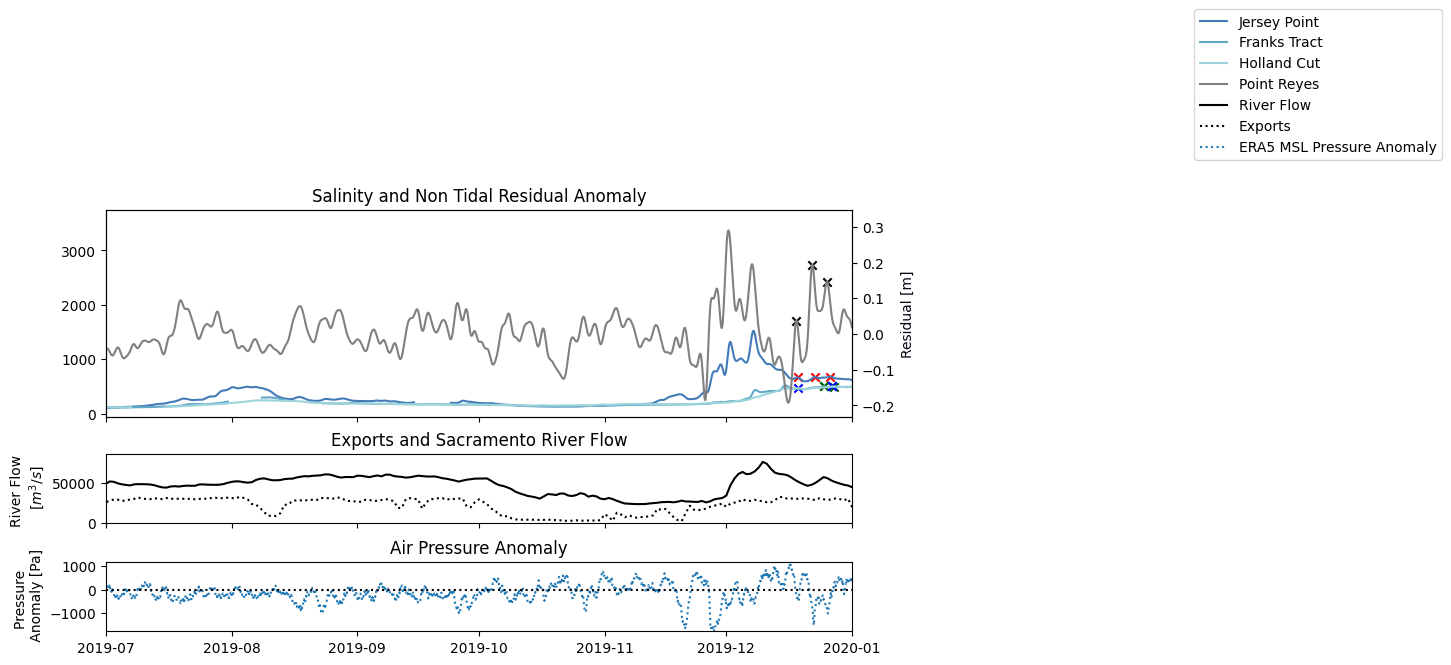

In [44]:
# Try plotting exports and river flow on a second thin subplot below the salinity and elevation plot and then a third plot for sea level pressure
fig, ax = plt.subplots(3,1,layout="constrained",sharex=True,figsize=(11,6),gridspec_kw={'height_ratios': [3, 1, 1]})

#Set the date limits of the plot HERE so I can rescale the axes by min and max in this range 
lim1=datetime(2019,7,1)
lim2=datetime(2020,1,1)
#colors to be consistent with other plors
colors = plt.colormaps['Dark2'].colors #this is a tuple so need to use tuple indexing [rom][column]


a, = ax[0].plot(df_f_wo21.jp,color=cmocean.cm.ice(3/6),label="Jersey Point")
ax[0].scatter(df_f_wo21.datetime.loc[peak_jp_both],df_f_wo21.jp.loc[peak_jp_both],marker="x",color='r')
b, = ax[0].plot(df_f_wo21.frk,color=cmocean.cm.ice(4/6),label="Franks Tract")
ax[0].scatter(df_f_wo21.datetime.loc[peak_frk_both],df_f_wo21.frk.loc[peak_frk_both],marker="x",color='darkgreen')
c, = ax[0].plot(df_f_wo21.hol2,color=cmocean.cm.ice(5/6),label="Holland Cut")
ax[0].scatter(df_f_wo21.datetime.loc[peak_hol2_both],df_f_wo21.hol2.loc[peak_hol2_both],marker="x",color='b')
ax0=ax[0].twinx()
d, = ax0.plot(pr_indices,df_f_wo21.pr.dropna(),color='grey', label="Point Reyes")
ax0.scatter(df_f_wo21.datetime.loc[peak_pr_both], df_f_wo21.pr.loc[peak_pr_both],marker="x",color='k')
ax0.set_ylabel("Residual [m]",color=cmocean.cm.ice(0))
ax[0].set_title('Salinity and Non Tidal Residual Anomaly')

e, = ax[1].plot(fluxc['sac_sjr']*-1, label="River Flow", color='k')
f, = ax[1].plot(fluxc['exports'], label="Exports", color='k',linestyle=':')
min1=fluxc[lim1:lim2][['sac_sjr','exports']].abs().min(axis=None).min()-2500
max1=fluxc[lim1:lim2][['sac_sjr','exports']].abs().max(axis=None).max()+10000
ax[1].set_ylim([min1,max1])
ax[1].set_ylabel("River Flow \n [$m^3/s$]")
ax[1].set_title('Exports and Sacramento River Flow')
#ax[1].legend()

g, = ax[2].plot(df_pr['msl_a'],label='ERA5 MSL Pressure Anomaly',linestyle=':')
min2=df_pr['msl_a'][lim1:lim2].min()-5
max2=df_pr['msl_a'][lim1:lim2].max()+5
ax[2].set_ylim([min2,max2])
ax[2].set_ylabel("Pressure \n Anomaly [Pa]")
ax[2].axhline(y=0, color = 'k',linestyle=':')
ax[2].set_title('Air Pressure Anomaly')

ax[0].set_xlim(lim1,lim2)
leg = plt.legend(handles=[a,b,c,d,e,f,g],loc='upper right', bbox_to_anchor=(1.8, 2.0))
plt.show()



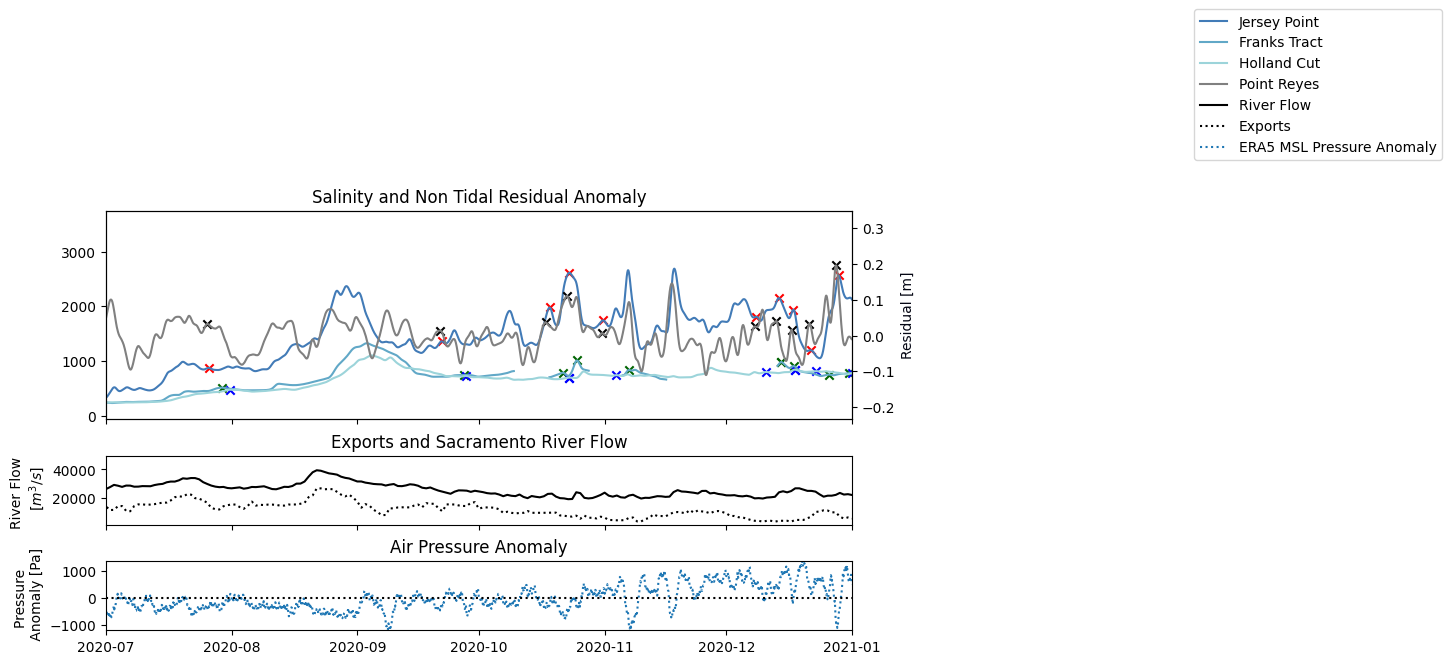

In [45]:
# Try plotting exports and river flow on a second thin subplot below the salinity and elevation plot and then a third plot for sea level pressure
fig, ax = plt.subplots(3,1,layout="constrained",sharex=True,figsize=(11,6),gridspec_kw={'height_ratios': [3, 1, 1]})

#Set the date limits of the plot HERE so I can rescale the axes by min and max in this range 
lim1=datetime(2020,7,1)
lim2=datetime(2021,1,1)
#colors to be consistent with other plors
colors = plt.colormaps['Dark2'].colors #this is a tuple so need to use tuple indexing [rom][column]


a, = ax[0].plot(df_f_wo21.jp,color=cmocean.cm.ice(3/6),label="Jersey Point")
ax[0].scatter(df_f_wo21.datetime.loc[peak_jp_both],df_f_wo21.jp.loc[peak_jp_both],marker="x",color='r')
b, = ax[0].plot(df_f_wo21.frk,color=cmocean.cm.ice(4/6),label="Franks Tract")
ax[0].scatter(df_f_wo21.datetime.loc[peak_frk_both],df_f_wo21.frk.loc[peak_frk_both],marker="x",color='darkgreen')
c, = ax[0].plot(df_f_wo21.hol2,color=cmocean.cm.ice(5/6),label="Holland Cut")
ax[0].scatter(df_f_wo21.datetime.loc[peak_hol2_both],df_f_wo21.hol2.loc[peak_hol2_both],marker="x",color='b')
ax0=ax[0].twinx()
d, = ax0.plot(pr_indices,df_f_wo21.pr.dropna(),color='grey', label="Point Reyes")
ax0.scatter(df_f_wo21.datetime.loc[peak_pr_both], df_f_wo21.pr.loc[peak_pr_both],marker="x",color='k')
ax0.set_ylabel("Residual [m]",color=cmocean.cm.ice(0))
ax[0].set_title('Salinity and Non Tidal Residual Anomaly')

e, = ax[1].plot(fluxc['sac_sjr']*-1, label="River Flow", color='k')
f, = ax[1].plot(fluxc['exports'], label="Exports", color='k',linestyle=':')
min1=fluxc[lim1:lim2][['sac_sjr','exports']].abs().min(axis=None).min()-2500
max1=fluxc[lim1:lim2][['sac_sjr','exports']].abs().max(axis=None).max()+10000
ax[1].set_ylim([min1,max1])
ax[1].set_ylabel("River Flow \n [$m^3/s$]")
ax[1].set_title('Exports and Sacramento River Flow')
#ax[1].legend()

g, = ax[2].plot(df_pr['msl_a'],label='ERA5 MSL Pressure Anomaly',linestyle=':')
min2=df_pr['msl_a'][lim1:lim2].min()-5
max2=df_pr['msl_a'][lim1:lim2].max()+5
ax[2].set_ylim([min2,max2])
ax[2].set_ylabel("Pressure \n Anomaly [Pa]")
ax[2].axhline(y=0, color = 'k',linestyle=':')
ax[2].set_title('Air Pressure Anomaly')

ax[0].set_xlim(lim1,lim2)
leg = plt.legend(handles=[a,b,c,d,e,f,g],loc='upper right', bbox_to_anchor=(1.8, 2.0))
plt.show()



In [25]:
min1

nan

In [31]:
lim1

datetime.datetime(2015, 7, 1, 0, 0)

In [33]:
fluxc.loc[lim1]

coyote                        -11.24
ccc_rock                   91.949997
ccc_old                          0.0
swp                       479.549988
cvp                       801.859985
sjr                      -358.480011
calaveras                        0.0
east                     -223.580002
american                 -8216.05957
sac                    -10461.879883
yolo_toedrain             301.839996
yolo                           -0.96
northbay                  108.919998
napa                             0.0
ccc_victoria              259.190002
sac_sjr                -10820.360352
exports                  1281.410034
md                             07-01
xaxis            2004-07-01 00:00:00
Name: 2015-07-01 00:00:00, dtype: object

In [38]:
fluxc.loc[lim1:lim2]

,coyote,ccc_rock,ccc_old,swp,cvp,sjr,calaveras,east,american,sac,yolo_toedrain,yolo,northbay,napa,ccc_victoria,sac_sjr,exports,md,xaxis
datetime,,,,,,,,,,,,,,,,,,,


In [35]:
fluxc.loc[lim1:lim2]#[['sac_sjr','exports']].abs().min(axis=None)

,coyote,ccc_rock,ccc_old,swp,cvp,sjr,calaveras,east,american,sac,yolo_toedrain,yolo,northbay,napa,ccc_victoria,sac_sjr,exports,md,xaxis
datetime,,,,,,,,,,,,,,,,,,,


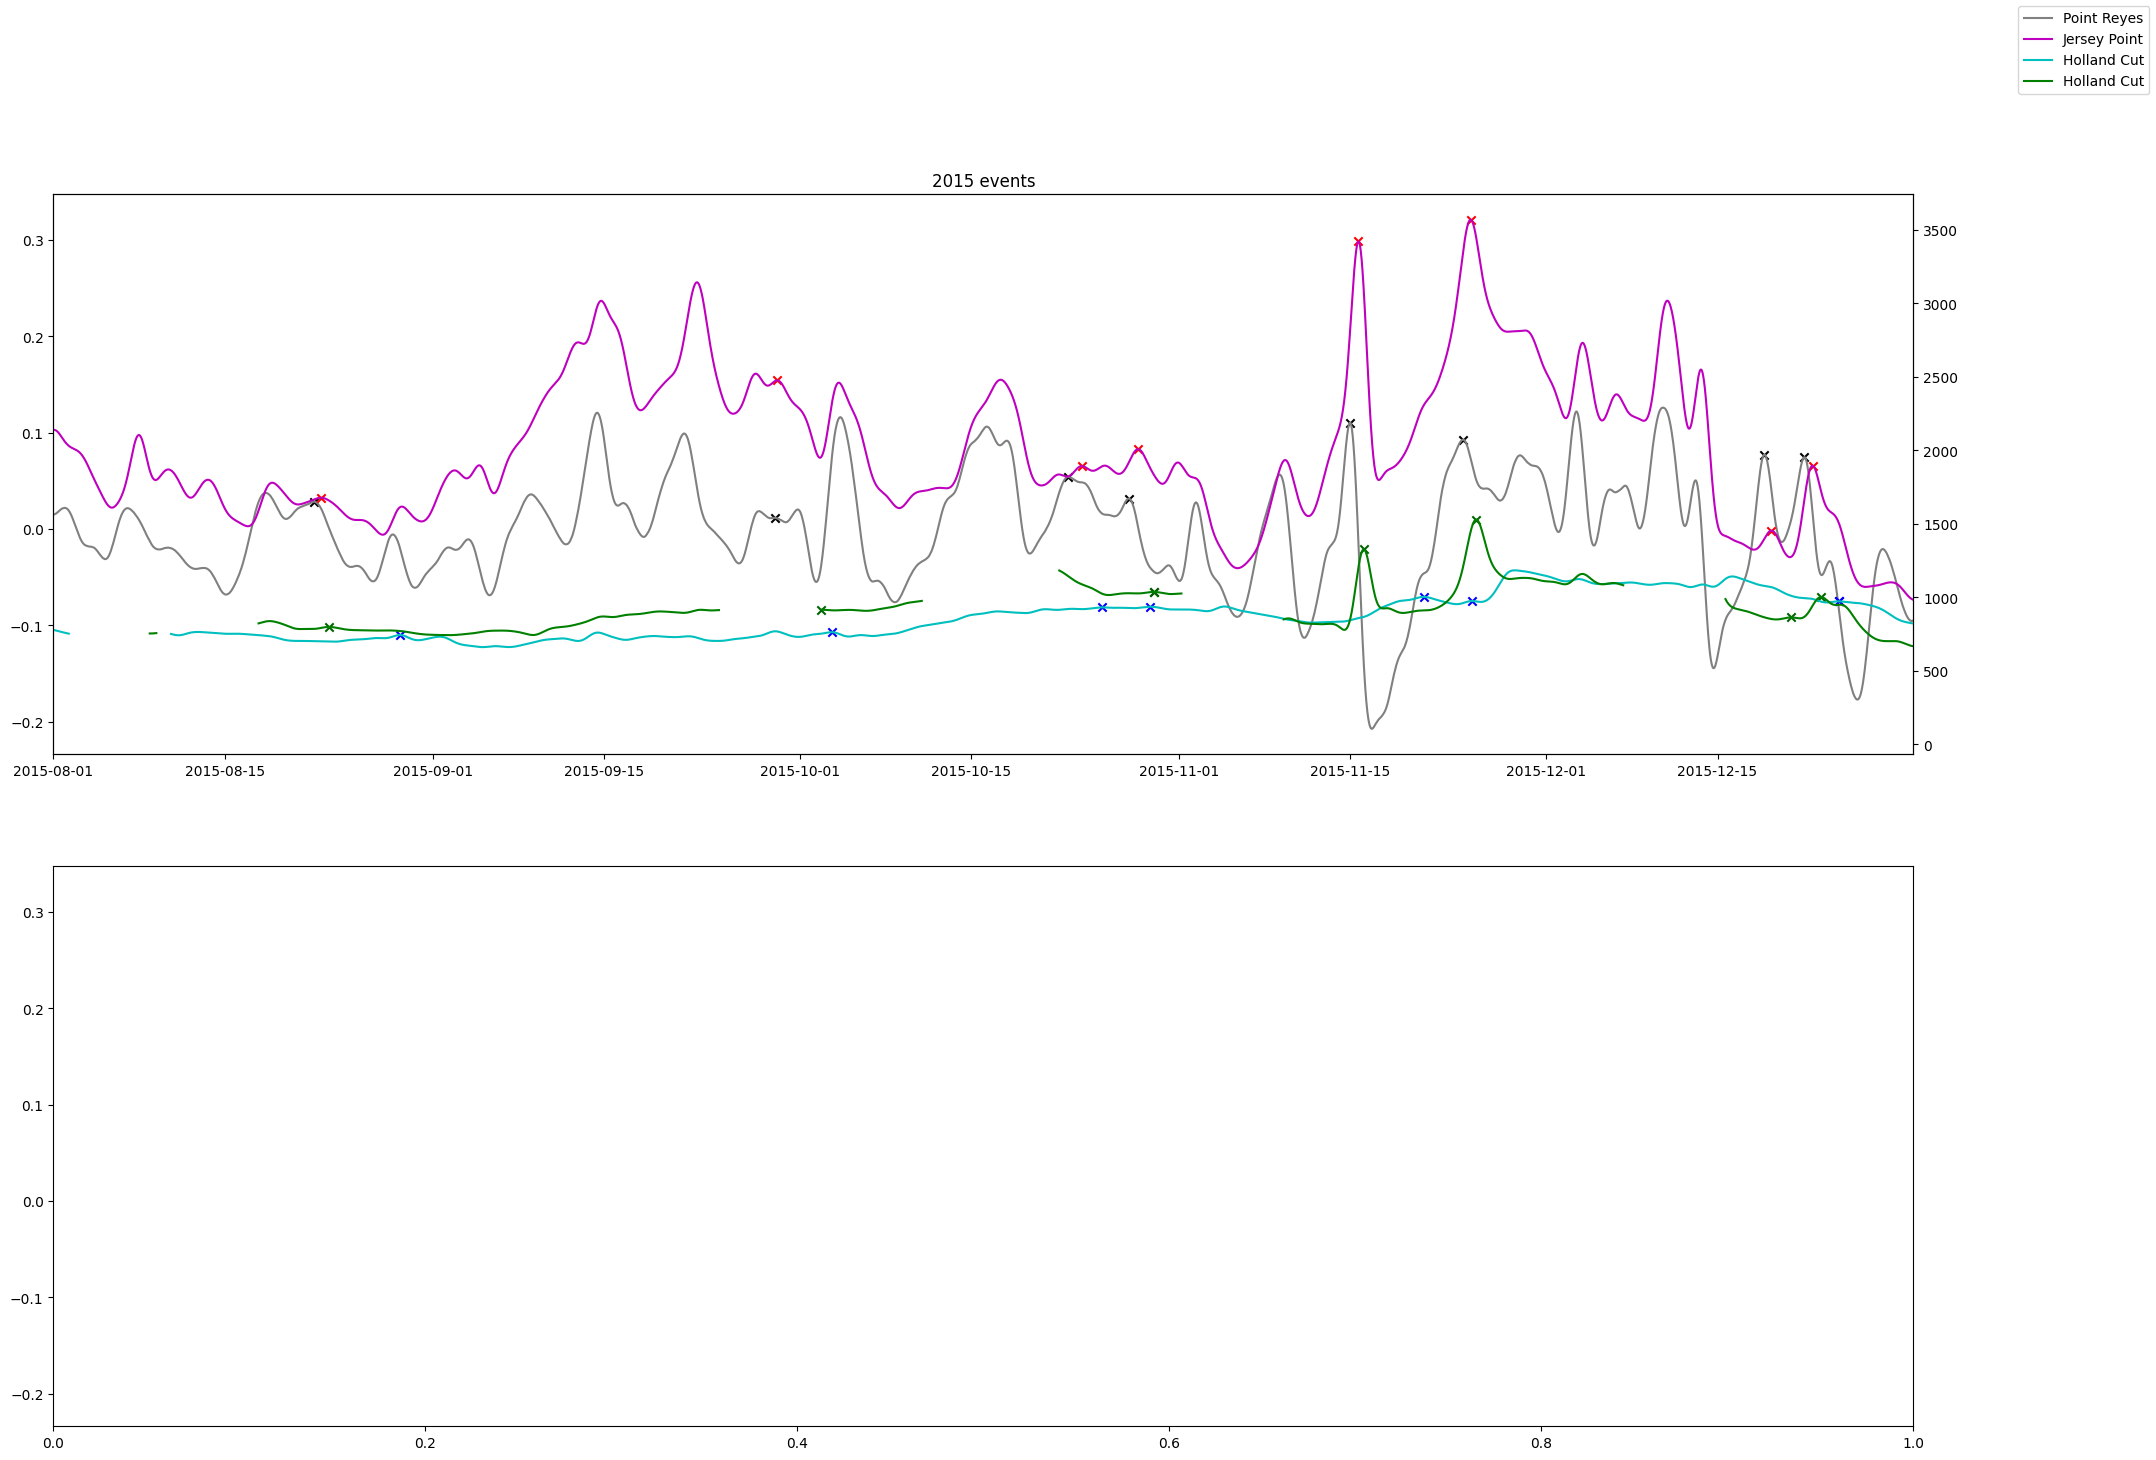

In [22]:
#Zoom into 2015
fig, ax =plt.subplots(2,1,sharey=True,figsize=(24,16))

ax[0].plot(pr_indices,df_f_wo21.pr.dropna(),color='grey', label="Point Reyes")
ax[0].scatter(df_f_wo21.datetime.loc[peak_pr_both], df_f_wo21.pr.loc[peak_pr_both],marker="x",color='k')
ax0=ax[0].twinx()
ax0.plot(df_f_wo21.jp,color='m',label="Jersey Point")
ax0.scatter(df_f_wo21.datetime.loc[peak_jp_both],df_f_wo21.jp.loc[peak_jp_both],marker="x",color='r')
ax0.plot(df_f_wo21.hol2,color='c',label="Holland Cut")
ax0.scatter(df_f_wo21.datetime.loc[peak_hol2_both],df_f_wo21.hol2.loc[peak_hol2_both],marker="x",color='b')
ax0.plot(df_f_wo21.frk,color='g',label="Holland Cut")
ax0.scatter(df_f_wo21.datetime.loc[peak_frk_both],df_f_wo21.frk.loc[peak_frk_both],marker="x",color='darkgreen')

ax[0].set_xlim([datetime(2015,8,1),datetime(2015,12,31)])
ax0.set_xlim([datetime(2015,8,1),datetime(2015,12,31)])
ax[0].set_title('2015 events')
fig.legend()
plt.show()